In this notebook we will be building and training LSTM to predict TESLA stock. We will use PyTorch.

## 1. Libraries and settings

In [ ]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if __name__ == '__main__':


## 2. Load data

In [ ]:
df.head()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/tsla_1min.xlsx'
df_tsla = pd.read_excel(path, usecols=['Local Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df_tsla.rename(columns={'Local Date': 'Date'}, inplace=True)
df_tsla.sort_values('Date', inplace=True)
df_tsla = df_tsla.set_index('Date')
df_tsla.head()

,Close,Open,Low,High,Volume
Date,,,,,
2022-05-11 10:01:00,812.84,813.04,803.04,814.00,3550.0
2022-05-11 10:02:00,811.51,812.79,811.51,813.00,2877.0
2022-05-11 10:03:00,812.60,811.89,810.36,812.60,3791.0
2022-05-11 10:04:00,809.60,812.36,809.17,813.00,1491.0
2022-05-11 10:05:00,808.90,808.88,808.33,809.71,654.0


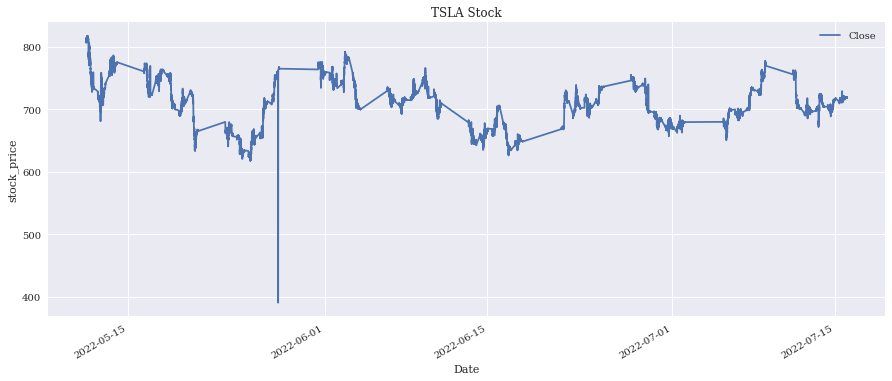

In [ ]:

df_tsla[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("TSLA Stock")
plt.show()

In [ ]:
df_tsla=df_tsla[['Close']]
df_tsla.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43200 entries, 2022-05-11 10:01:00 to 2022-07-16 02:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   43197 non-null  float64
dtypes: float64(1)
memory usage: 675.0 KB


In [ ]:
df_tsla=df_tsla.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_tsla['Close'] = scaler.fit_transform(df_tsla['Close'].values.reshape(-1,1))
#df_ibm

In [ ]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_tsla, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (34512, 59, 1)
y_train.shape =  (34512, 1)
x_test.shape =  (8628, 59, 1)
y_test.shape =  (8628, 1)


In [ ]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
y_train.size(),x_train.size()

(torch.Size([34512, 1]), torch.Size([34512, 59, 1]))

## 3. Build the structure of model

In [ ]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [ ]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.04923219233751297
Epoch  20 MSE:  0.030032677575945854
Epoch  30 MSE:  0.018068749457597733
Epoch  40 MSE:  0.002476430032402277
Epoch  50 MSE:  0.0014246647479012609
Epoch  60 MSE:  0.0006794921355322003
Epoch  70 MSE:  0.00043058316805399954
Epoch  80 MSE:  0.00032429827842861414
Epoch  90 MSE:  0.00024496231344528496


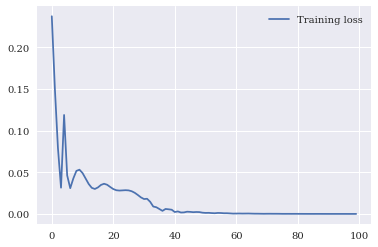

In [ ]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [ ]:
np.shape(y_train_pred)

torch.Size([34512, 1])

In [ ]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.22 RMSE
Test Score: 1.68 RMSE


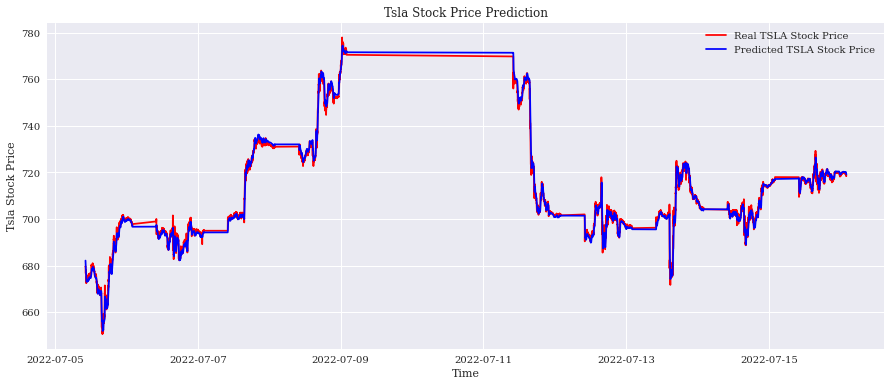

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_tsla[len(df_tsla)-len(y_test):].index, y_test, color = 'red', label = 'Real TSLA Stock Price')
axes.plot(df_tsla[len(df_tsla)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted TSLA Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Tsla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tsla Stock Price')
plt.legend()
plt.savefig('tsla_pred.png')
plt.show()